In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib

In [2]:
# Read CSV files into pandas DataFrames
stations_dynamic_df = pd.read_csv("ExportedData/stations_dynamic.csv")
stations_static_df = pd.read_csv("ExportedData/stations_static.csv")
weather_data_df = pd.read_csv("ExportedData/weather_data.csv")

# Display the first few rows of each DataFrame to understand the data structure
print("Stations Dynamic Data:")
print(stations_dynamic_df.head())
print("\nStations Static Data:")
print(stations_static_df.head())
print("\nWeather Data:")
print(weather_data_df.head())

# Perform some simple analysis
# Example: Calculate the average temperature from weather data
average_temperature = weather_data_df["temperature"].mean()
print("\nAverage Temperature:", average_temperature)

# Example: Count the number of bike stations
num_stations = len(stations_static_df)
print("Number of Bike Stations:", num_stations)

# Example: Find the most common main events in weather data
common_main_events = weather_data_df["main_event"].value_counts().head()
print("\nMost Common Main Events:")
print(common_main_events)

Stations Dynamic Data:
   id  number                  name  banking  bonus status  \
0   1      42      SMITHFIELD NORTH        0      0   OPEN   
1   2      30  PARNELL SQUARE NORTH        0      0   OPEN   
2   3      54        CLONMEL STREET        0      0   OPEN   
3   4     108         AVONDALE ROAD        0      0   OPEN   
4   5      20     JAMES STREET EAST        0      0   OPEN   

           last_update           api_update  available_bikes  \
0  2024-02-21 00:59:33  2024-02-21 01:00:25               30   
1  2024-02-21 00:51:51  2024-02-21 01:00:25                0   
2  2024-02-21 00:50:28  2024-02-21 01:00:25                3   
3  2024-02-21 00:51:03  2024-02-21 01:00:25               25   
4  2024-02-21 00:52:14  2024-02-21 01:00:25                0   

   available_bike_stands  bike_stands  
0                      0           30  
1                     20           20  
2                     30           33  
3                     10           35  
4                  

In [3]:
### Drop duplicates rows as we did a few extra scrapping, we will keep weather.
stations_dynamic_df.drop_duplicates(subset=['number', 'last_update'], keep='last')

### Transform dates 
stations_dynamic_df['last_update'] = pd.to_datetime(stations_dynamic_df['last_update'])
weather_data_df['timestamp'] = pd.to_datetime(weather_data_df['timestamp'])

# Drop duplicate rows from stations_dynamic_df keeping the last occurrence
stations_dynamic_df = stations_dynamic_df.drop_duplicates(subset=['number', 'last_update'], keep='last')
weather_data_df = weather_data_df.drop_duplicates(subset=['timestamp'], keep='last')
stations_dynamic_df.sort_values('last_update', inplace=True)
weather_data_df.sort_values('timestamp', inplace=True)

# Filter the DataFrames based on the condition
stations_dynamic_df = stations_dynamic_df[stations_dynamic_df['last_update'] >= '2024-02-25 14:27:18']
weather_data_df = weather_data_df[weather_data_df['timestamp'] >= '2024-02-25 14:27:18']


merged_df = pd.merge_asof(stations_dynamic_df, weather_data_df, left_on='last_update', right_on='timestamp', direction='nearest')
print(merged_df)

           id_x  number                               name  banking  bonus  \
0        149925      98             FREDERICK STREET SOUTH        0      0   
1        150069       4                       GREEK STREET        0      0   
2        150059       9                   EXCHEQUER STREET        0      0   
3        149930     112  NORTH CIRCULAR ROAD (O'CONNELL'S)        0      0   
4        150130      40                      JERVIS STREET        0      0   
...         ...     ...                                ...      ...    ...   
577904  1091085       3                      BOLTON STREET        0      0   
577905  1090998      23                       CUSTOM HOUSE        0      0   
577906  1091021      97                    KILMAINHAM GAOL        0      0   
577907  1091048      69                   GRAND CANAL DOCK        0      0   
577908  1091073     100             HEUSTON BRIDGE (SOUTH)        0      0   

       status         last_update           api_update  availab

In [4]:
merged_df.drop(columns=['last_update', 'api_update','status','banking','bonus', 'id_x','id_y'], inplace=True)
print(merged_df)

        number                               name  available_bikes  \
0           98             FREDERICK STREET SOUTH               26   
1            4                       GREEK STREET               10   
2            9                   EXCHEQUER STREET               15   
3          112  NORTH CIRCULAR ROAD (O'CONNELL'S)               11   
4           40                      JERVIS STREET               21   
...        ...                                ...              ...   
577904       3                      BOLTON STREET                5   
577905      23                       CUSTOM HOUSE               27   
577906      97                    KILMAINHAM GAOL                3   
577907      69                   GRAND CANAL DOCK               38   
577908     100             HEUSTON BRIDGE (SOUTH)                9   

        available_bike_stands  bike_stands           timestamp  temperature  \
0                          14           40 2024-02-25 14:27:18         7.70   
1

In [5]:
merged_df['timestamp'] = merged_df['timestamp'].dt.round('10min')

# Separate day of the week and hour per day from the timestamp
merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek
merged_df['hour_per_day'] = merged_df['timestamp'].dt.hour
print(merged_df.head())


   number                               name  available_bikes  \
0      98             FREDERICK STREET SOUTH               26   
1       4                       GREEK STREET               10   
2       9                   EXCHEQUER STREET               15   
3     112  NORTH CIRCULAR ROAD (O'CONNELL'S)               11   
4      40                      JERVIS STREET               21   

   available_bike_stands  bike_stands           timestamp  temperature  \
0                     14           40 2024-02-25 14:30:00          7.7   
1                     10           20 2024-02-25 14:30:00          7.7   
2                      9           24 2024-02-25 14:30:00          7.7   
3                     19           30 2024-02-25 14:30:00          7.7   
4                      0           21 2024-02-25 14:30:00          7.7   

  main_event  rain_hour_day  feels_like  humidity  wind_speed    description  \
0     Clouds            0.0        3.22        81        9.77  broken clouds   
1   

Mean Squared Error: 30.241958293875825


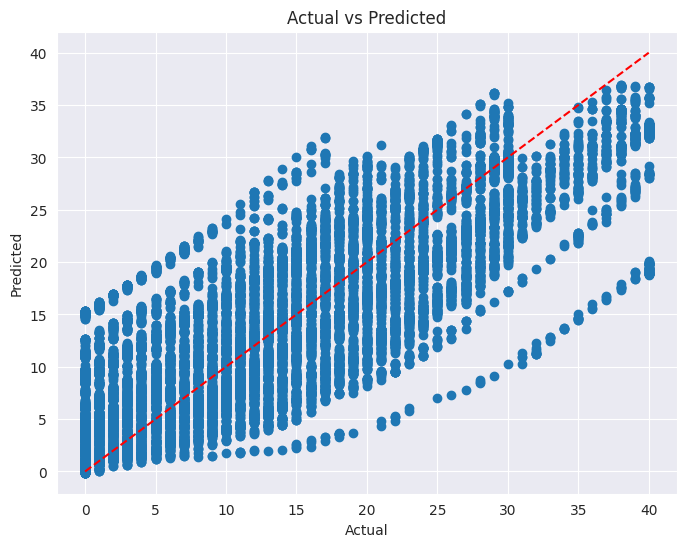

In [7]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Define features and target variable
X = merged_df[['number', 'day_of_week', 'hour_per_day', 'rain_hour_day', 'temperature', 'wind_speed', 'available_bike_stands']].head(100000)
y = merged_df['available_bikes'].head(100000)  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a support vector machine regressor
svm_regressor = SVR()
svm_regressor.fit(X_train, y_train)
joblib.dump(svm_regressor, 'svm_regressor_model.pkl')

# Make predictions on the test set
y_pred = svm_regressor.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # identity line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

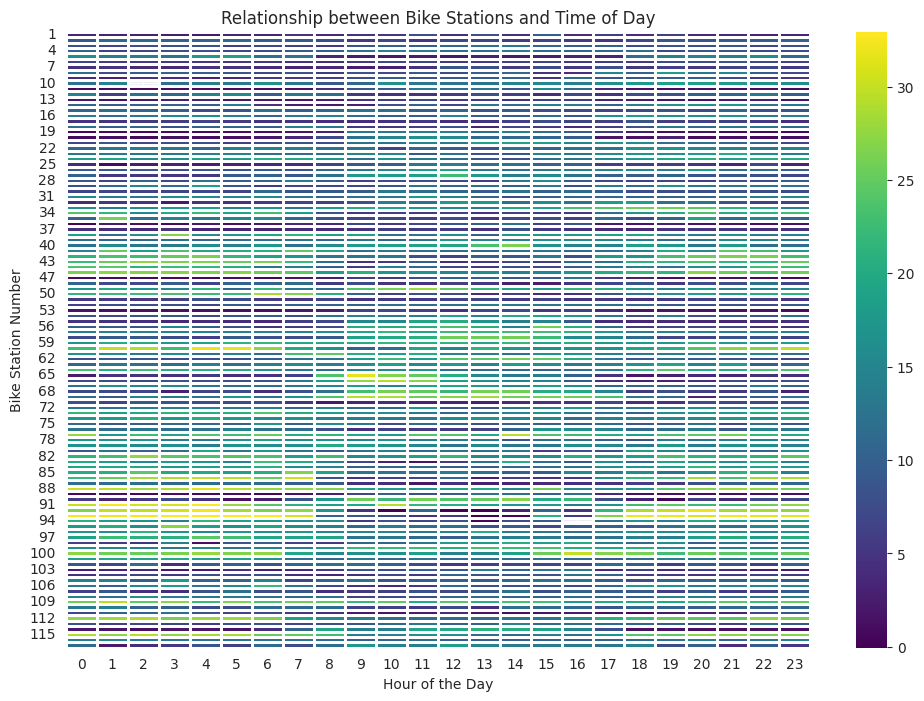

In [19]:


# Combine features and predictions for test data
test_data_with_predictions = X_test.copy()
test_data_with_predictions['Predicted Available Bikes'] = y_pred

# Pivot the table to get the relationship between bike stations, time of the day, and predicted available bikes
pivot_table = test_data_with_predictions.pivot_table(index='number', columns='hour_per_day', values='Predicted Available Bikes', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', linecolor='white', linewidth=1)
plt.title('Relationship between Bike Stations and Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Bike Station Number')
plt.show()


In [ ]:
# Pivot the table to get the relationship between bike stations, time of the day, and predicted available bikes
pivot_table = test_data_with_predictions.pivot_table(index='number', columns='hour_per_day', values='Predicted Available Bikes', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', linecolor='white', linewidth=1)
plt.title('Relationship between Bike Stations and Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Bike Station Number')
plt.show()


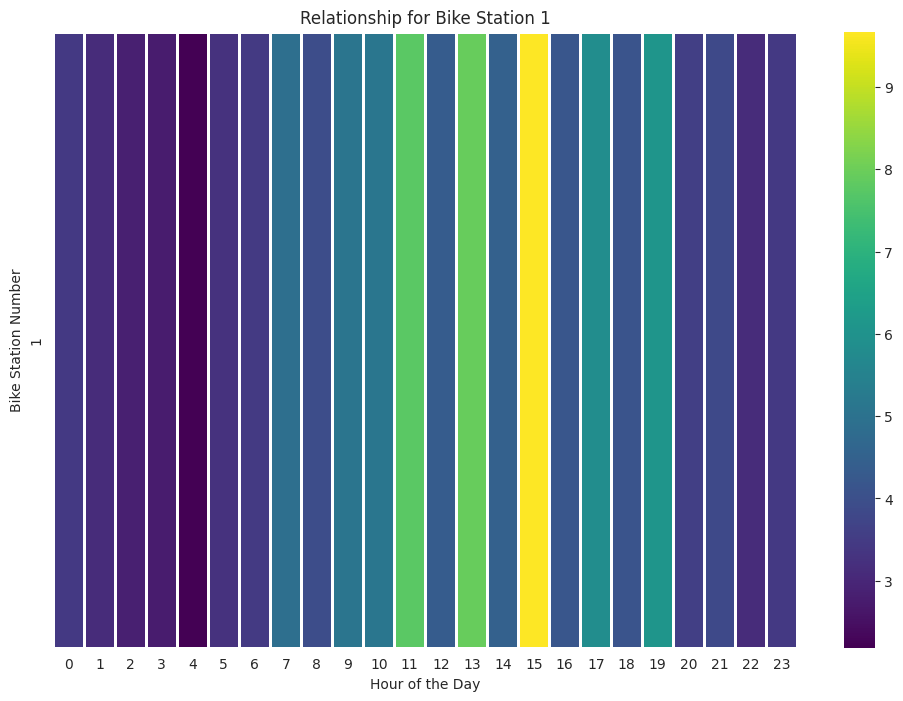

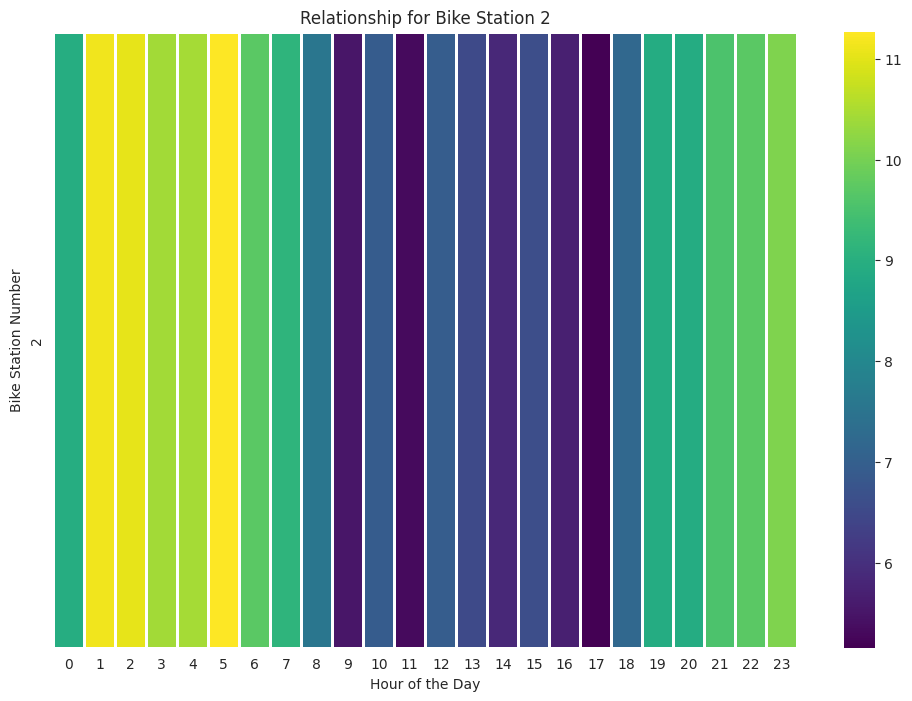

In [18]:

def plot_heatmap(station):
    pivot_table = station.pivot_table(index='number', columns='hour_per_day', values='Predicted Available Bikes', aggfunc='mean')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='viridis', linecolor='white', linewidth=1)
    plt.title('Predicted Available Bikes for ' + station)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Bike Station Number')
    plt.show()

# Example of creating multiple plots
# Suppose you want to create plots for different bike stations
# You can filter the data for each bike station and call the plot_heatmap function for each subset

# Example for bike station 1
station_1_data = test_data_with_predictions[test_data_with_predictions['number'] == 1]

plot_heatmap(station_1_data, 'Relationship for Bike Station 1')

# Example for bike station 2
station_2_data = test_data_with_predictions[test_data_with_predictions['number'] == 2]
plot_heatmap(station_2_data, 'Relationship for Bike Station 2')

# Repeat the process for other bike stations as needed
